In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/sheppLoganEdgeMap'
OutputDir='/scratch/TESTS/Aim2/sheppLoganEdgeMap'

in_fn = os.path.join(InputDir,'sheppLogan.png')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

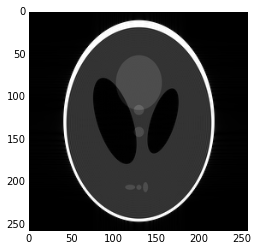

In [4]:
inputImage = sitk.ReadImage(in_fn)
myshow(inputImage)

In [6]:
# Now t1d and t2d have original t1, t2 voxel lattice with following specifications:
print(inputImage.GetSize())
print(inputImage.GetDirection())
print(inputImage.GetOrigin())

(256, 256)
(1.0, 0.0, 0.0, 1.0)
(0.0, 0.0)


In [11]:
stats = sitk.StatisticsImageFilter()
stats.Execute(inputImage)
inputImageMax = stats.GetMaximum()
inputImageMin = stats.GetMinimum()
inputImageMean = stats.GetMean()

print(inputImageMax)
print(inputImageMin)
print(inputImageMean)

255.0
0.0
32.18359375


In [7]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

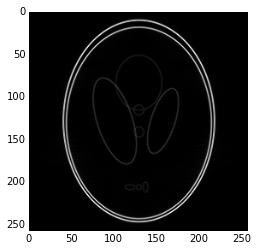

In [8]:
gradMagImage = sitk.GradientMagnitude(inputImage)
myshow(gradMagImage)

In [10]:
stats = sitk.StatisticsImageFilter()
stats.Execute(gradMagImage)
gradMagImageMax = stats.GetMaximum()
gradMagImageMin = stats.GetMinimum()
gradMagImageMean = stats.GetMean()

print(gradMagImageMax)
print(gradMagImageMin)
print(gradMagImageMean)

173.358016968
0.0
5.51588857557


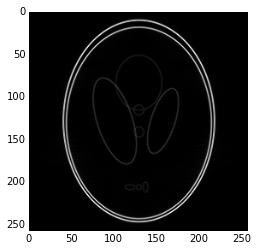

In [73]:
# Now normalize both t1g and t2g to have values between 0 and 1
edgeMask = NormalizeBetweenZeroAndOne(gradMagImage)
myshow(edgeMask)

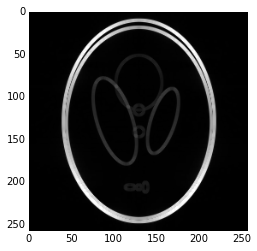

In [74]:
# use mask dilation
dil = sitk.GrayscaleDilateImageFilter()
edgeMask = dil.Execute(edgeMask)
myshow(edgeMask)
#edgeMask = dil.Execute(edgeMask)
#myshow(edgeMask)

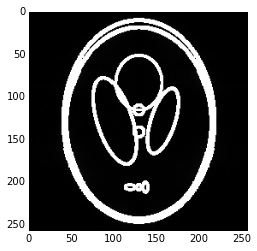

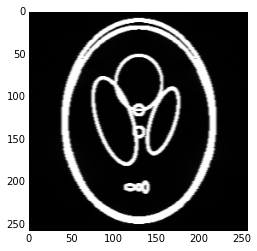

In [75]:
# Threshold values
thres = sitk.ThresholdImageFilter()
threshedgeMask = thres.Execute(edgeMask,0,0.05,1)
myshow(threshedgeMask)

# Use a gaussian smoothing
#gauss = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gauss = sitk.RecursiveGaussianImageFilter ()
gaussedgemask = gauss.Execute(threshedgeMask)
myshow(gaussedgemask)

#edgeMask = NormalizeBetweenZeroAndOne(gaussedgemask)

In [76]:
# invert the edge mask
inverter = sitk.InvertIntensityImageFilter()
edgeMask = inverter.Execute(edgeMask,1)

In [77]:
totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1.0
0.0


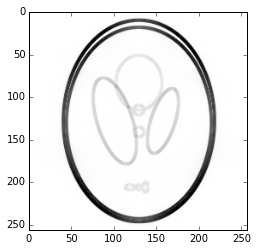

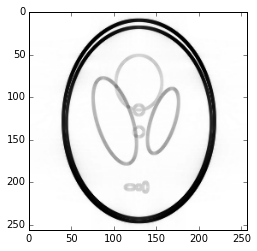

In [78]:
myshow(edgeMask)

#sqrtedgeMask = sitk.Sqrt(edgeMask)
sqredgeMask = sitk.Square(edgeMask)

myshow(sqredgeMask)

In [79]:
print(edgeMask.GetOrigin())
#edgeMask.SetOrigin([edgeMask.GetOrigin()[0]+0.5,edgeMask.GetOrigin()[1]+0.5])
#print(edgeMask.GetOrigin())

(0.0, 0.0)


In [80]:
edge_arr = sitk.GetArrayFromImage(sqredgeMask)
#edge_arr = sitk.GetArrayFromImage(edgeMask)

import scipy.io
scipy.io.savemat(os.path.join(OutputDir,'edgemask2.mat'), mdict={'edgemask': edge_arr})